# 1. Importing Libraries

In [1]:
import os
import pandas as pd
import torch
import torchvision

from typing import List
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets

from modules.helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from modules.engine import Trainer

NNUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
#target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 288

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_test = v2.Compose([        
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_resnetb2_transforms = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

In [4]:
print(f"Default EfficientNetB2 transforms: {pretrained_resnetb2_transforms}")

Default EfficientNetB2 transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [5]:
# Setup the directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"

# Make the directories
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# 3. Image Visualization

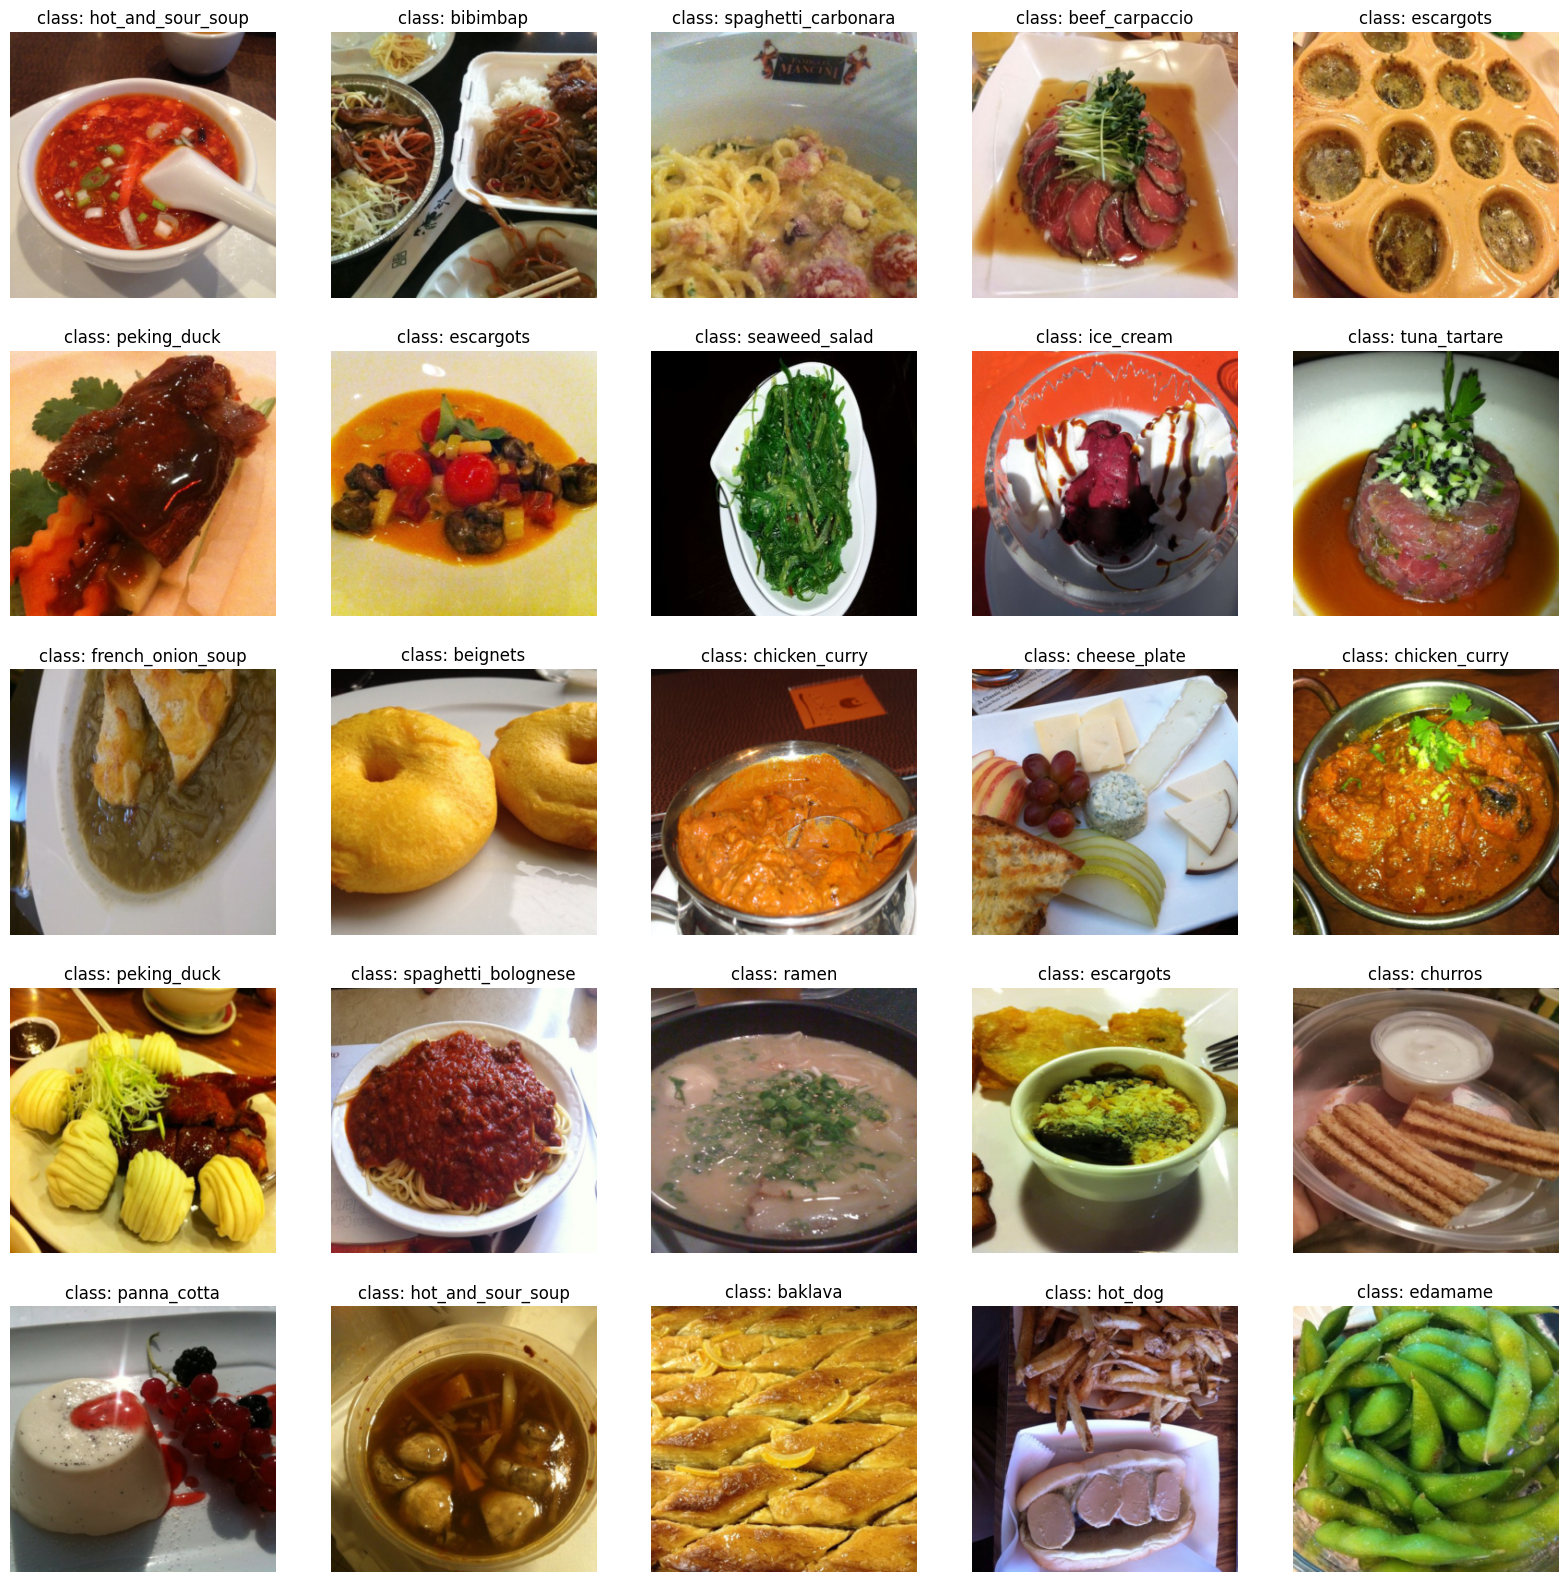

In [ ]:
with torch.device("cpu"):
    train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
    display_random_images(train_data,
                          n=25,
                          classes=class_names,
                          rows=5,
                          cols=5,
                          display_shape=False,
                          seed=None)

# 4. Baseline Model: EfficientNet B2

In [7]:
def create_effnetb2(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        hidden_units: int=1024,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=1408, 
                        out_features=hidden_units, # same number of output units as our number of classes
                        bias=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=hidden_units, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)
    )

    return model, weights

In [ ]:
# Create data loaders
BATCH_SIZE = 64
HIDDEN_UNITS = 1024
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# Instantiate the model
effnetb2_model, _ = create_effnetb2_v2(transfer_learning=False,
                                         hidden_units=1024,
                                         class_names=class_names)

# Compile model
effnetb2_model = torch.compile(effnetb2_model, backend='aot_eager')

# And a summary
summary(effnetb2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0103 19:07:22.344000 24216 site-packages\torch\_dynamo\convert_frame.py:844] [9/8] torch._dynamo hit config.cache_size_limit (8)
W0103 19:07:22.344000 24216 site-packages\torch\_dynamo\convert_frame.py:844] [9/8]    function: '_scale' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torchvision\ops\misc.py:251)
W0103 19:07:22.344000 24216 site-packages\torch\_dynamo\convert_frame.py:844] [9/8]    last

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [64, 3, 288, 288]    [64, 101]            --                   True
├─EfficientNet (_orig_mod)                                        [64, 3, 288, 288]    [64, 101]            --                   True
│    └─Sequential (features)                                      [64, 3, 288, 288]    [64, 1408, 9, 9]     --                   True
│    │    └─Conv2dNormActivation (0)                              [64, 3, 288, 288]    [64, 32, 144, 144]   928                  True
│    │    └─Sequential (1)                                        [64, 32, 144, 144]   [64, 16, 144, 144]   2,060                True
│    │    └─Sequential (2)                                        [64, 16, 144, 144]   [64, 24, 72, 72]     27,424               True
│    │    └─Sequential (3)                               

Epoch: 10 | train_loss: 1.1497 | train_acc: 0.9054 | fpr_at_recall: 0.0038 | train_time: 6m22s | test_loss: 1.1703 | test_acc: 0.8803 | fpr_at_recall: 0.0063 | test_time: 1m38s | lr: 0.0000034227


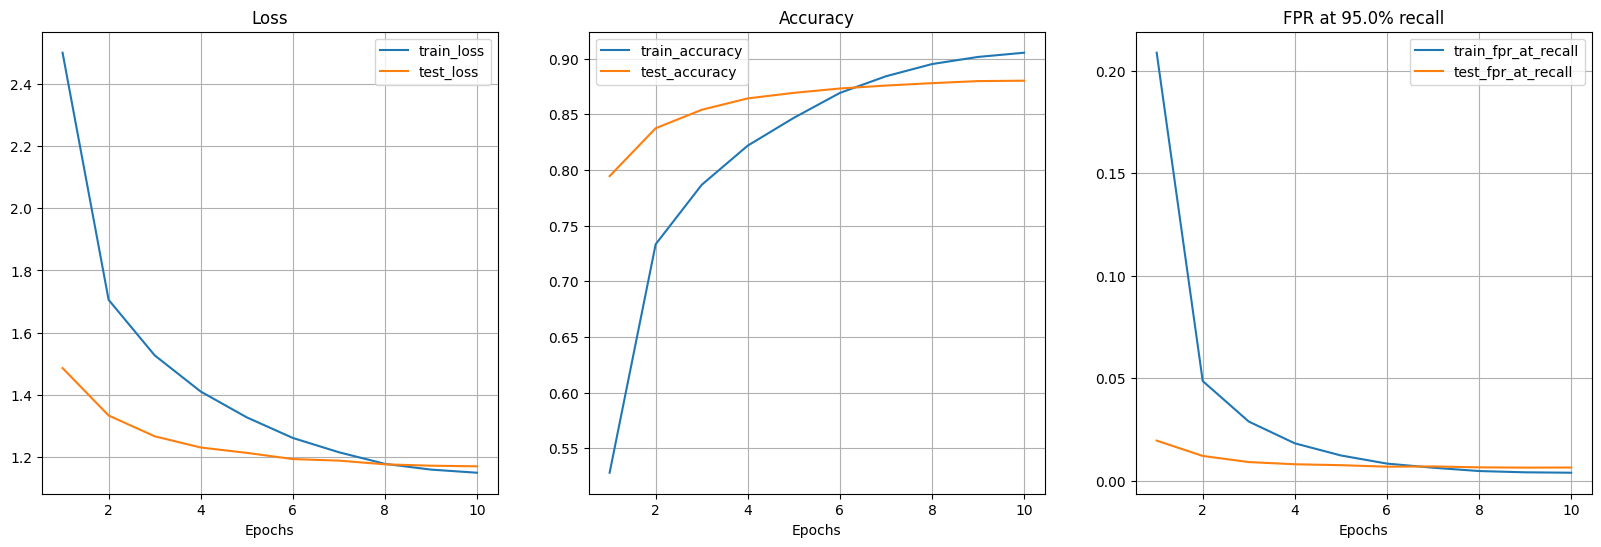

[INFO] Saving model to: ..\models\effnetb2_best.pth
[INFO] Saving model to: ..\models\effnetb2.pth


In [ ]:
# Configure the model
model_type="effnetb2"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
effnetb2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(params=effnetb2_model.parameters(),
                            lr=LR,
                            betas=(0.9, 0.999),
                            weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=effnetb2_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

effnetb2_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=effnetb2_model_name,
    train_dataloader=train_dataloader_b2,
    test_dataloader=test_dataloader_b2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )